<a href="https://colab.research.google.com/github/alextsab/Pneumonia_Detection/blob/main/New_Densenet_201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Pneumonia_Detection/labels_train.csv'

In [3]:
import numpy as np 
import pandas as pd 
import os
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from keras.applications.densenet import preprocess_input

from keras import layers
from keras.preprocessing import image
from keras_preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model, load_model
import keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import DenseNet201

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [4]:
import pandas as pd
train_labels=pd.read_csv("/content/drive/MyDrive/Pneumonia_Detection/labels_train.csv",dtype=str)
training_dir = '/content/drive/MyDrive/Pneumonia_Detection/train_images'
test_dir = '/content/drive/MyDrive/Pneumonia_Detection/test_images'


print(train_labels.to_string())

                        file_name class_id
0     img_4358977458434011046.jpg        1
1     img_5224016757187192130.jpg        2
2     img_3065202206106254707.jpg        2
3     img_6304894865561547174.jpg        1
4     img_3371338542810939877.jpg        2
5      img_946797649386887230.jpg        0
6     img_3282952127033205295.jpg        0
7     img_3090153597350897926.jpg        1
8     img_4875755942606271156.jpg        1
9     img_4787814488043878610.jpg        1
10    img_4125543106305495129.jpg        1
11    img_2823915539277173272.jpg        0
12    img_7230268662919234934.jpg        1
13    img_6848561975587852457.jpg        1
14     img_920571004437917321.jpg        2
15    img_5530061828133861346.jpg        1
16    img_2651683821313937633.jpg        2
17    img_6250877799855221825.jpg        2
18    img_5739013355534223830.jpg        2
19    img_3753314631059921298.jpg        2
20    img_2835374355015172473.jpg        1
21    img_4552190304152050945.jpg        1
22    img_1

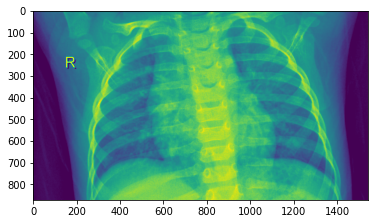

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(training_dir + '/img_946797649386887230.jpg')
imgplot = plt.imshow(img)
plt.show()

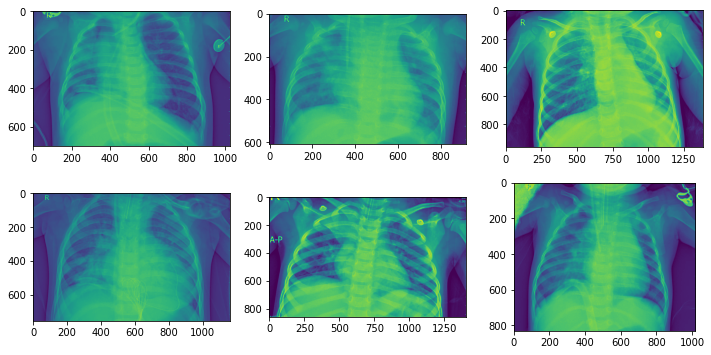

In [6]:
import os

def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1


plot_images(training_dir + '/')

In [7]:
# Filename του μοντέλου
onoma_montelou = 'new_final.h5'

# Διάσταση εικόνων 
img = (224, 224)

# Πλήθος εποχών
epochs = 30

# Αριθμός κατηγοριών που θα γίνει η ταξινόμηση.
classes = 3

# Σύνολο εικόνων που θα τροφοδοτούμε το μοντέλο. 
# Παράδειγμα, άν έχουμε 1000 εικόνες για εκπαίδευση, 
# και BATCH_SIZE = 10 τότε, 1000/10 = 100 παρτίδες σε μια εποχή. 
batchSize = 128

In [8]:
traindataframe = pd.read_csv("/content/drive/MyDrive/Pneumonia_Detection/labels_train.csv",dtype=str)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.4,
        fill_mode='nearest')


train_generator = datagen.flow_from_dataframe(
    dataframe=traindataframe,
    directory="/content/drive/MyDrive/Pneumonia_Detection/train_images",
    x_col="file_name",
    y_col="class_id",
    subset="training",
    interpolation='nearest',
    batch_size=batchSize,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=img)

valid_generator = datagen.flow_from_dataframe(
    dataframe=traindataframe,
    directory="/content/drive/MyDrive/Pneumonia_Detection/train_images",
    x_col="file_name",
    y_col="class_id",
    subset="validation",
    interpolation='nearest',
    batch_size=1,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=img)

Found 2804 validated image filenames belonging to 3 classes.
Found 1868 validated image filenames belonging to 3 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory = "/content/drive/MyDrive/Pneumonia_Detection/test_images",    
    batch_size = 1,
    seed = 42,
    class_mode = None,
    shuffle = False,
    target_size = img)

Found 1168 images belonging to 1 classes.


In [11]:
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPool2D
from keras.models import Sequential
from keras import layers


metrics = ['accuracy']

early_stop = EarlyStopping(patience=10, monitor='loss',
                                              restore_best_weights=True,
                                              verbose=1)

conv_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = Flatten()(conv_model.output)
x = Dense(100, activation='relu')(x)
x= Dropout(0.25)(x)
x= Dense(1024,activation='relu')(x) 
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x= Dropout(0.25)(x)



predictions = Dense(3, activation='softmax')(x)
full_model = Model(inputs=conv_model.input, outputs=predictions)

full_model=Model(inputs=conv_model.input,outputs=predictions)
full_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = metrics)
full_model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [12]:
model_dense = DenseNet201(include_top=False,
                          weights='imagenet',
                         )
x = model_dense.output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128,activation='relu')(x) 
x = Dense(64,activation='sigmoid')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(classes, activation='softmax')(x)

my_model = Model(inputs=model_dense.input, outputs=predictions)

In [13]:
for layer in model_dense.layers:
    layer.trainable = False

# Compile του μοντέλου με βελτιστοποιητή adam
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor = 0.3,
                              patience = 3, 
                              min_lr = 0.000001, 
                              verbose = 1)

checkpoint = ModelCheckpoint(onoma_montelou, 
                             monitor = 'val_accuracy', 
                             mode = 'max', 
                             save_best_only = True, 
                             verbose = 1)

callbacksList = [reduce_lr,checkpoint]

In [15]:
model_history = my_model.fit(
        train_generator,
        validation_data = valid_generator,
        batch_size = batchSize,
        epochs = epochs,
        callbacks = callbacksList,
        verbose=1
         ) 

Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 0.8866 - accuracy: 0.6081
Epoch 1: val_accuracy improved from -inf to 0.69379, saving model to new_final.h5
22/22 [==============================] - 179s 7s/step - loss: 0.8866 - accuracy: 0.6081 - val_loss: 0.9551 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.7114 - accuracy: 0.6919
Epoch 2: val_accuracy improved from 0.69379 to 0.72323, saving model to new_final.h5
22/22 [==============================] - 137s 6s/step - loss: 0.7114 - accuracy: 0.6919 - val_loss: 0.9157 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.7229
Epoch 3: val_accuracy improved from 0.72323 to 0.74036, saving model to new_final.h5
22/22 [==============================] - 135s 6s/step - loss: 0.6672 - accuracy: 0.7229 - val_loss: 0.8660 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 4/30
22/22 [===================

In [16]:
for i, layer in enumerate(model_dense.layers):
   print(i, layer.name)

# Θα παγώσουμε τις πρώτες 249 στρώσεις και θα ξεπαγώσουμε τις υπόλοιπες
for layer in my_model.layers[:249]:
   layer.trainable = False
for layer in my_model.layers[249:]:
   layer.trainable = True 

0 input_2
1 zero_padding2d_2
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_3
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [17]:
from tensorflow.keras.optimizers import SGD
my_model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_history = my_model.fit(
        train_generator,
        validation_data = valid_generator,
        batch_size = batchSize,
        epochs = epochs,
        callbacks = callbacksList,
        verbose=1
         )


Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.7250
Epoch 1: val_accuracy did not improve from 0.80675
22/22 [==============================] - 185s 7s/step - loss: 0.6418 - accuracy: 0.7250 - val_loss: 0.5768 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.7636
Epoch 2: val_accuracy did not improve from 0.80675
22/22 [==============================] - 148s 7s/step - loss: 0.5870 - accuracy: 0.7636 - val_loss: 0.5539 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.5374 - accuracy: 0.7775
Epoch 3: val_accuracy did not improve from 0.80675
22/22 [==============================] - 147s 7s/step - loss: 0.5374 - accuracy: 0.7775 - val_loss: 0.5172 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7796
Epoch 4: val_accuracy did not improve from

In [19]:
import os;
print(os.getcwd())

/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

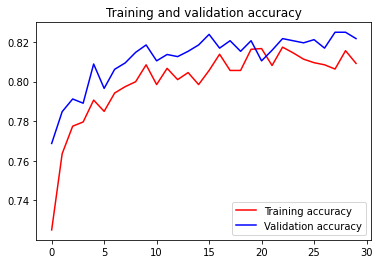

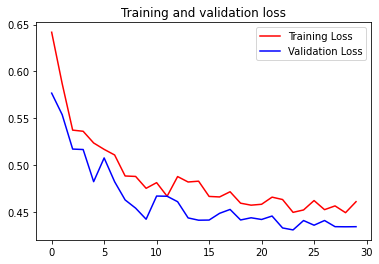

In [20]:
import matplotlib.pyplot as plt
from google.colab import files

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


epochs = range(len(acc))
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.savefig('accuracy.pdf')

files.download('accuracy.pdf')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig('Loss.pdf')

files.download('Loss.pdf')

plt.show()

In [21]:
# %% [code] {"execution":{"iopub.status.busy":"2022-01-06T23:29:50.343814Z","iopub.execute_input":"2022-01-06T23:29:50.345539Z","iopub.status.idle":"2022-01-06T23:31:22.141957Z","shell.execute_reply.started":"2022-01-06T23:29:50.345490Z","shell.execute_reply":"2022-01-06T23:31:22.141257Z"}}
# Αποθήκευση του μοντέλου.
my_model.save(onoma_montelou)

In [22]:
acc = my_model.evaluate(valid_generator)
print(acc)

1868/1868 [==============================] - 82s 44ms/step - loss: 0.4351 - accuracy: 0.8228
[0.4351133406162262, 0.8228051662445068]


In [23]:
STEP_SIZE_TEST = 1168

In [24]:
new_my_model = load_model(onoma_montelou)


In [25]:
test_generator.reset()

In [26]:
pred = new_my_model.predict(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
print("\n\nΤα preds είναι: \n\n")
print(pred)

# Αποθήκευση στην μεταβλητή predicted_class_indices, 
# για κάθε εικόνα, την θέση της μεγαλύτερης τιμής του πίνακα pred. 
predicted_class_indices=np.argmax(pred,axis=1)
print("\n\nTα predicted_class_indices είναι: \n\n")
print(predicted_class_indices)

# Παίρνουμε τις κλάσεις/ετικέτες κάθε εικόνας, απο το train set. 
# Κατασκευάζουμε και εμφανίζουμε ένα αντικείμενο της μορφής {'0': 0, '1': 1, '2': 2}
labels = (train_generator.class_indices)
print("\n\nTα labels είναι: \n\n")
print(labels)

1168/1168 [==============================] - 357s 304ms/step


Τα preds είναι: 


[[0.9929806  0.00166538 0.00535397]
 [0.22726831 0.44146657 0.3312652 ]
 [0.9863973  0.00358348 0.01001913]
 ...
 [0.11470527 0.5986974  0.2865973 ]
 [0.00139599 0.79884005 0.19976398]
 [0.9914535  0.0020688  0.00647761]]


Tα predicted_class_indices είναι: 


[0 1 0 ... 1 1 0]


Tα labels είναι: 


{'0': 0, '1': 1, '2': 2}


In [27]:
labels = dict((v,k) for k,v in labels.items())
print("\n\nΤα labels είναι τώρα: \n\n")
print(labels)

# Κατασκευή λίστας predictions. To k διατρέχει τον πίνακα predicted_class_indices
# και η τιμή του labels[k] αποθηκεύεται στη λίστα predictions ως string.
predictions = [labels[k] for k in predicted_class_indices]
print("\n\nΤα  predictions είναι: \n\n")
print(predictions)



Τα labels είναι τώρα: 


{0: '0', 1: '1', 2: '2'}


Τα  predictions είναι: 


['0', '1', '0', '1', '0', '0', '1', '2', '1', '0', '0', '1', '0', '1', '1', '2', '2', '1', '0', '1', '1', '1', '0', '2', '1', '1', '0', '2', '1', '1', '2', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '2', '2', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '2', '1', '1', '0', '2', '0', '0', '0', '0', '0', '0', '2', '1', '2', '0', '1', '2', '0', '0', '1', '2', '0', '1', '0', '0', '1', '0', '0', '0', '0', '2', '0', '0', '1', '1', '2', '0', '1', '2', '1', '0', '1', '0', '0', '0', '1', '1', '2', '0', '2', '1', '1', '1', '0', '1', '2', '0', '1', '1', '0', '2', '0', '0', '1', '0', '1', '0', '2', '1', '1', '0', '2', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '1', '2', '1', '1', '1', '1', '1', '0', '2', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '2', '1', '2', '2', '0', '2', '0', '1', '1', '2', '1', '1', '0', '1',

In [28]:
filenames = test_generator.filenames
print("\n\nTα filenames είναι: \n")
print(filenames)

#Δημιουργία και εμφάνιση του τελικού πίνακα που περιέχει τις εικόνες του test set και δίπλα την κλάση που το μοντέλο προέβλεψε.
data = {
    "file_name": filenames,
    "class_id": predictions
}
my_dataframe = pd.DataFrame(data)
print("\n\nTo my_dataframe είναι: \n\n")
print(my_dataframe)



Tα filenames είναι: 

['test_images/img_1005556732793955351.jpg', 'test_images/img_1013947992995844467.jpg', 'test_images/img_1037372824298815463.jpg', 'test_images/img_1037910048520457739.jpg', 'test_images/img_1046182996541873496.jpg', 'test_images/img_1055155538793908277.jpg', 'test_images/img_1056493789828791097.jpg', 'test_images/img_1063539320518541645.jpg', 'test_images/img_1067627733181002215.jpg', 'test_images/img_1069295317302009938.jpg', 'test_images/img_1082179150533558647.jpg', 'test_images/img_1084571077180415795.jpg', 'test_images/img_1085919836874816265.jpg', 'test_images/img_1089446545260563550.jpg', 'test_images/img_1102208210595046337.jpg', 'test_images/img_1123863876791783558.jpg', 'test_images/img_1125305094391727652.jpg', 'test_images/img_1128297347845871447.jpg', 'test_images/img_1129866115399804592.jpg', 'test_images/img_1131369692869272887.jpg', 'test_images/img_1135497390116745149.jpg', 'test_images/img_1136104169519514555.jpg', 'test_images/img_113945781825

In [30]:
my_dataframe.to_csv("09022023.csv",index=False)